In [1]:
# Import libraries

In [2]:
import requests 
import pandas as pd
import numpy as np
import scipy.stats as si
import datetime
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Define pricing functions

In [4]:
def BS_Price(S, K, T, r, sigma, p_c):
    
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = (np.log(S / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    
    if p_c == 'C':
        result = (S * si.norm.cdf(d1, 0.0, 1.0) - K * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0))
    elif p_c == 'P':
        result = (K * np.exp(-r * T) * si.norm.cdf(-d2, 0.0, 1.0) - S * si.norm.cdf(-d1, 0.0, 1.0))
        
    return result

In [5]:
def BS_IV(S, K, T, r, price, p_c):
    
    finalIV = 1
    dIV = 0.01
    thresholdPx = 0.001
    
    for i in range(100):
        thisPx = BS_Price(S, K, T, r, finalIV, p_c)
        dPx = BS_Price(S, K, T, r, finalIV + dIV, p_c) - thisPx
        finalIV = finalIV + (price - thisPx) / dPx * dIV
        if dPx <= thresholdPx:
            break
            
    return finalIV

In [6]:
# Function to convert ddmmmyy date format to days from today

In [7]:
def Date_reformat(date_ddmmmyy):
    
    return (datetime.datetime.strptime(date_ddmmmyy + 'UTC08', '%d%b%y%Z%H') - datetime.datetime.utcnow()).total_seconds() / 86400


In [8]:
# Function to pull data from Deribit and output into a dictionary

In [9]:
def Get_option_data(asset):
    
    url_option_data = f'https://www.deribit.com/api/v2/public/get_book_summary_by_currency?currency={asset}&kind=option'
    json_option_data = requests.get(url = url_option_data).json() 
    result_option_book = json_option_data['result']
    
    for i in result_option_book:
        instrument_name = i['instrument_name']
        instrument_data = instrument_name.split("-")
        underlying = instrument_data[0]
        expiry = instrument_data[1]
        strike = float(instrument_data[2])
        putcall = instrument_data[3]
        TTE = Date_reformat(expiry)/365.25
        underlying_price = float(i['underlying_price'])
        mid_price = i['mid_price']

        if mid_price == None:
            i['mid_IV'] = None
        else:
            i['mid_IV'] = BS_IV(underlying_price,strike,TTE,0,float(mid_price)*underlying_price,putcall)

    return result_option_book


In [10]:
output = Get_option_data('ETH')

In [11]:
# Extract just the data points we need

In [12]:
new_list = []

for i in range(0,len(output)):
    
    a = output[i].get('instrument_name')
    b = output[i].get('open_interest')
    c = a.split("-")[1]
    d = a.split("-")[2]
    e = a.split("-")[3]
    f = output[i].get('mid_IV')
    g = output[i].get('underlying_price')
    h = Date_reformat(c)/365.25
    j = {'open_interest': b, 'expiry': c, 'strike': d, 'p_c': e, 'ivol': f, 'fwd_point': i, 'TTM': h}
    
    new_list.append(j)
    

In [13]:
# Create Dataframe

In [14]:
new_df = pd.DataFrame(new_list)

In [15]:
# Convert inf to na and drop na

In [16]:
new_df.replace([np.inf, -np.inf], np.nan, inplace=True)
new_df.dropna(inplace=True)

In [17]:
# Convert put/call to numeric values -1/1

In [18]:
new_df.replace('P', -1, inplace=True)
new_df.replace('C', 1, inplace=True)

In [19]:
# Filter out low OI strikes and those with extreme Ivol values

In [20]:
new_df = new_df[(new_df['open_interest'] > 1000) & (new_df['ivol'] < 1.5)]

In [21]:
# Remove columns we don't need for our feature set and define our target

In [22]:
X = new_df.drop(columns=['ivol', 'expiry', 'open_interest'])
y = new_df['ivol']

In [23]:
# Import scikit learn libraries

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import PredictionErrorDisplay

In [25]:
# Split our data

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=35)

In [27]:
# Define our scaler and apply to the feature set and target values

In [28]:
scaler = StandardScaler()
y_scaler = StandardScaler()

In [29]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1))

In [30]:
# Define candidate the parameters for the SVR

In [31]:
params_grid = {'C': [1, 10, 100],
               'gamma': [0.01, 0.1, 1],
               'cache_size': [3, 5, 10],
               'degree': [1, 2, 3],
               'kernel': ['linear', 'rbf']}

In [32]:
# Run optimisation

In [33]:
clf = GridSearchCV(estimator=SVR(), 
                    param_grid=params_grid,
                    cv=5,
                    refit=True,
                    error_score=0,
                    n_jobs=-1)

clf.fit(X_train_scaled, y_train_scaled.ravel())
optimised_svr = clf.best_estimator_
optimised_svr

SVR(C=100, cache_size=3, degree=1, gamma=0.1)

In [34]:
# Run the SVR

In [35]:
clf = make_pipeline(StandardScaler(),SVR(C=100, cache_size=3, coef0=0.0, degree=1, epsilon=0.01, gamma=0.1,
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False))

clf.fit(X_train_scaled, y_train_scaled)
    
y_pred_scaled = clf.predict(X_test_scaled)

In [36]:
# Inverse the scaler

In [37]:
y_pred = y_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1))

In [38]:
# Calculate performance metrics

In [39]:
print("A descriptive measure, the MSE calculates the mean of the errors squared.")
print("Mean squared error: %.4f" % mean_squared_error(y_test, y_pred, squared=True))
print("")
print("R^2 measuress the proportion of variance (of y) that has been explained by the independent variables in the model.")
print("Coefficient of determination (R^2): %.4f" % r2_score(y_test, y_pred))

A descriptive measure, the MSE calculates the mean of the errors squared.
Mean squared error: 0.0026

R^2 measuress the proportion of variance (of y) that has been explained by the independent variables in the model.
Coefficient of determination (R^2): 0.8202


In [40]:
# Two charts to visualise the fit of the model and the residuals

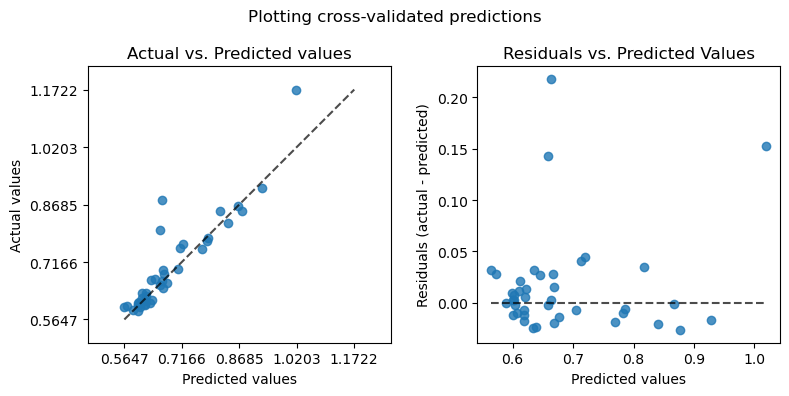

In [41]:
fig, axs = plt.subplots(ncols=2, figsize=(8, 4))
PredictionErrorDisplay.from_predictions(
    y_test,
    y_pred=y_pred,
    kind="actual_vs_predicted",
    subsample=100,
    ax=axs[0],
    random_state=0,
)
axs[0].set_title("Actual vs. Predicted values")
PredictionErrorDisplay.from_predictions(
    y_test.values,
    y_pred=y_pred.reshape(1,-1).tolist()[0],
    kind="residual_vs_predicted",
    subsample=100,
    ax=axs[1],
    random_state=0,
)
axs[1].set_title("Residuals vs. Predicted Values")
fig.suptitle("Plotting cross-validated predictions")
plt.tight_layout()
plt.show()

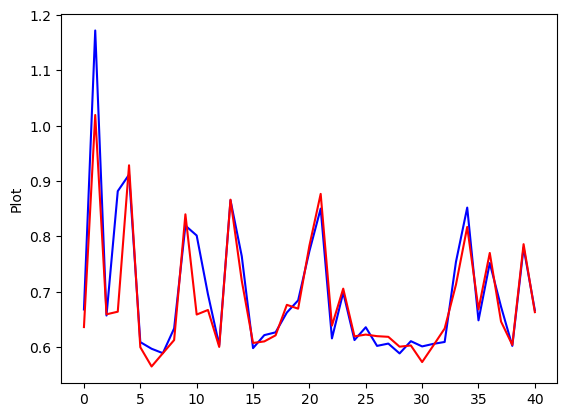

In [42]:
plt.plot(y_test.values, '-', color='blue')
plt.plot(y_pred, '-', color='red')
plt.ylabel('Plot')
plt.show()